In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
%matplotlib inline
import seaborn as sns
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py


SRP_name = 'aggregates'
resolution = '100kbp_raw' 
species= 'mouse'

In [4]:

df_seq_depth = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_exclude_count_inter.txt', sep='\t')

In [6]:

            contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
            df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

In [7]:
vector_list = []
for proj in df_con['id'].tolist():
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{proj}/100kbp_raw/max/hic_inter_all_contacts_vector.h5', 'r') as hf:
                     data =  (((hf[proj][()])));
                     print (proj)
                     vector_list.append(data)
                
        

SRP249897
SRP292639
SRP217487
SRP075985
SRP105082
SRP110616
SRP118601
SRP200567
SRP223513
SRP218950
SRP226118
SRP194410
SRP156597
SRP107774
SRP270993
SRP250878
SRP101928
SRP247488
SRP229756
SRP144391
SRP179647
SRP096571
SRP227097
SRP119332
SRP268173
SRP192917
SRP100871
SRP252213
ERP114475
SRP255620
SRP165933
SRP131117
SRP261290


In [8]:
arr = np.vstack(vector_list)

In [9]:
dist_arr = np.corrcoef(arr)

In [10]:
dist_arr

array([[1.        , 0.99415053, 0.89776038, ..., 0.97694739, 0.98857305,
        0.9432789 ],
       [0.99415053, 1.        , 0.90215237, ..., 0.98684426, 0.99527042,
        0.95314096],
       [0.89776038, 0.90215237, 1.        , ..., 0.92169472, 0.91227769,
        0.88986976],
       ...,
       [0.97694739, 0.98684426, 0.92169472, ..., 1.        , 0.9884219 ,
        0.97011514],
       [0.98857305, 0.99527042, 0.91227769, ..., 0.9884219 , 1.        ,
        0.95875706],
       [0.9432789 , 0.95314096, 0.88986976, ..., 0.97011514, 0.95875706,
        1.        ]])

<AxesSubplot:>

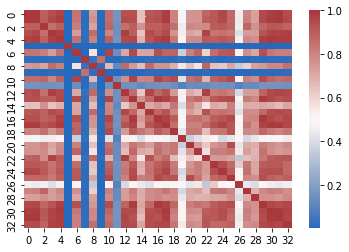

In [11]:
sns.heatmap(dist_arr, cmap="vlag")

In [18]:
SRP_name = 'aggregates'
resolution = '1kbp_raw' 
species= 'mouse'

In [19]:
input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
bins_bed['bin_id'] = bins_bed.index
bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')

In [20]:
def calc_auroc (df_trial,predicted_score='predicted_score'):
    df_trial = df_trial.sort_values(by=[predicted_score], ascending=False)
    rank_abs = lambda x: stats.rankdata(x)
    predicts2 = np.apply_along_axis(rank_abs, 0, df_trial[predicted_score].values)
    df_trial['p'] = [y if x==1 else 0 for x,y in zip(df_trial['true_pos'], predicts2)]
    #print (df_trial['p'].sum())
    if df_trial['true_neg'].sum() == 0 or df_trial['true_pos'].sum() == 0:
        return np.nan
    else:
        return (((df_trial['p'].sum() /df_trial['true_pos'].sum() )- (df_trial['true_pos'].sum() + 1)/2)) / df_trial['true_neg'].sum()



In [21]:

            contacts_path = f'/grid/gillis/data/nfox/hi_c_data_processing/data_{species}/stats/'
            df_con = pd.read_csv(f'{contacts_path}/project_network_counts.txt', sep=' ', names=['id', 'count'])

            import pandas as pd
            empty_list = []
            empty_list_2 = []
            empty_list_3 = []
            counter = 0

            for proj in df_con['id'].tolist():
                
                with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{proj}/{resolution}/max/hic_inter_bins_mean_none.h5', 'r') as hf:
    
                     data =  (((hf['mean'][()])));
                df_max_gene_inter_by_bins = pd.DataFrame(data)
                df_max_gene_inter_by_bins['proj'] = proj
                df_max_gene_inter_by_bins = df_max_gene_inter_by_bins.reset_index()

                df_max_gene_inter_by_bins = df_max_gene_inter_by_bins.merge(bins_bed, left_on='index', right_on='bin_id')

                df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

                df_cre['start_bin'] = df_cre['start']/1000
                df_cre['start_bin'] = df_cre['start_bin'].astype('int')
                df_cre['start_bin'] = df_cre['start_bin']*1000
                df_cre['start_bin'] = df_cre['start_bin'].astype('str')
                df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
                #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
                df_cre['cre'] = 1
                df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
                df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')
                



                

                df_cre_tog = df_cre_1kb_encode.merge(df_max_gene_inter_by_bins, left_on='pos', right_on='pos', how='right')

                df_cre_tog['cre'] = df_cre_tog['cre'].fillna(0)
                
                
                
                df_cre_tog['true_pos'] =  [1 if x>=1 else 0 for x in df_cre_tog['cre']]
                
                df_cre_tog['true_neg'] = [0 if x == 1 else 1 for x in df_cre_tog['true_pos']]

                df_cre_tog['score'] = df_cre_tog[0]
                
                df_cre_tog = df_cre_tog[df_cre_tog['score'] != 0]

                
                #df_cre_tog = df_cre_tog[df_cre_tog['bin_id_y'].isin(gene_data['bin'].tolist())]
                #df_cre_tog = df_cre_tog[~df_cre_tog['bin_id_y'].isin(gene_data['bin_end'].tolist())]
                
                #empty_list.append((df_cre_tog[df_cre_tog['cre']>=2][0].mean()  - df_cre_tog[df_cre_tog['cre']==1][0].mean())/df_cre_tog[df_cre_tog['cre']>=1][0].mean())
                #U, p_val = mannwhitneyu(df_cre_tog[df_cre_tog['cre']>=2][0].tolist(), df_cre_tog[df_cre_tog['cre']==1][0].tolist(), alternative="greater")
                #empty_list_3.append(p_val)
                
                empty_list.append(calc_auroc (df_cre_tog,predicted_score='score'))
                print (calc_auroc (df_cre_tog,predicted_score='score'))


                
    
                
                df_seq_depth_subset = df_seq_depth[df_seq_depth['proj_id'].isin([proj])]
                empty_list_2.append(df_seq_depth_subset['counts_inter'].sum())
                

0.5024545028806343
0.45614451663137895
0.6054054408286883
0.684997078049809
0.6626459708317665
0.40850883630579643
0.6860553660322682
0.43364881175448017
0.6288578636332647
0.448912707787867
0.6395727638664017
0.4207396991444202
0.5436735133568197
0.6517000986774216
0.625789786751124
0.6203907189869038
0.6182165558086776
0.6634613606747534
0.6603022878546355
0.5148562815227772
0.6957560571358749
0.565596185646957
0.5888405551981956
0.5254301886680144
0.5158763289802919
0.588026477856648
0.5258880976099223
0.6168800480520035
0.5868129739357787
0.6366798232647424
0.6307134762033701
0.5295478861504042
0.5718065483322595


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

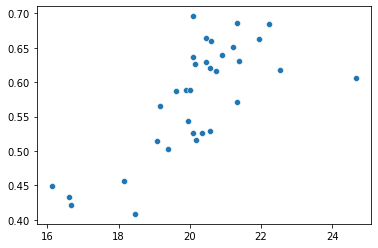

In [22]:
sns.scatterplot([np.log(x) for x in (empty_list_2)], (empty_list))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

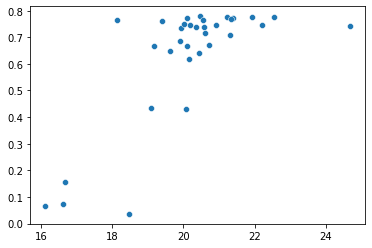

In [25]:
sns.scatterplot([np.log(x) for x in (empty_list_2)], dist_arr.mean(axis=1))